# Pedometer Design Program

Following code below loads the parameter of filters and constant variables

In [3]:
# Constant Variable of Program
SAMPLING_RATE = 20
NUM_AUTOCORR_LAGS = 340

## 1) Import Data of Accelerometer from csv file

The algorithm works with acceleration magnitude, need to convert (x, y, z) acceleration into magnitude values.

Num Steps: 42.0
Num Samples: 469
Delta Time: 0


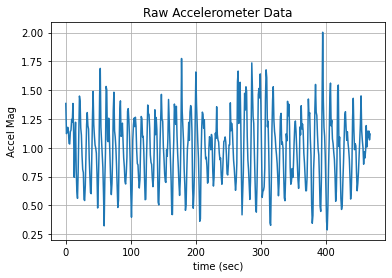

In [4]:
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("data/walking/trail5.csv")
time = data.iloc[:, 0].values
accelx = data.iloc[:, 1].values
accely = data.iloc[:, 2].values
accelz = data.iloc[:, 3].values
steps = data.iloc[:, 4].values[0]
print("Num Steps: " + str(steps))
print("Num Samples: " + str(len(accelx)))
print("Delta Time: " + str(time[0]))

# the theroetical max sampling time of the MPU is 1kHz
mag = []
for i, x in enumerate(accelx):
    mag.append(math.sqrt((accelx[i]**2)+(accely[i]**2)+(accelz[i]**2)))

plt.plot(time, mag)
plt.xlabel("time (sec)")
plt.ylabel("Accel Mag")
plt.title("Raw Accelerometer Data")
plt.grid()
plt.show()

## 2) Apply Low Pass Filter to Data

The parameters of the low pass filter need to calibrated for our accelometer. It should remove high frequency noise from the acceleration signals. Using FIR style filter for easier implementation, the parameter of FIR filter can be determine used Matlab Tools or Scipy python tools.

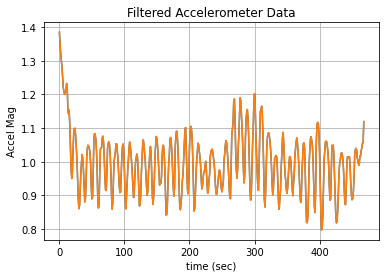

In [5]:
import numpy as np



def lpf(x, omega_c, T):
    N = len(x)-1
    y = x
    alpha = (2-T*omega_c)/(2+T*omega_c)
    beta = T*omega_c/(2+T*omega_c)
    for k in range(1, N):
        y[k] = alpha*y[k-1] + beta*(x[k]+x[k-1])
    return y

omega = 2.0 * np.pi * (2) / 2.0                 # Cut-off Frequency
T = 0.05                   # Sampling time

lpf_mag = lpf(mag, omega, T)
plt.plot(time, lpf_mag)
plt.plot(time, mag)
plt.xlabel("time (sec)")
plt.ylabel("Accel Mag")
plt.title("Filtered Accelerometer Data")
plt.grid()
plt.show()

## 3) Remove Mean 

This removes the DC offset of signal, this can be done using Gussian Filter, Mean Filter or Low pass filter.

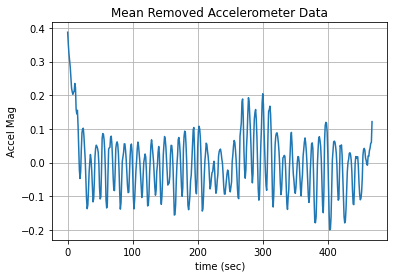

In [6]:
mean = 0 
for i, m in enumerate(mag):
    mean += m
mean = mean / len(mag)
for i, m in enumerate(mag):
    mag[i] = mag[i] - mean

plt.plot(time, mag)
plt.xlabel("time (sec)")
plt.ylabel("Accel Mag")
plt.title("Mean Removed Accelerometer Data")
plt.grid()
plt.show()

# 4) Autocorrelation

Autocorelation convolves signal with original signal delay to extract the peaks.

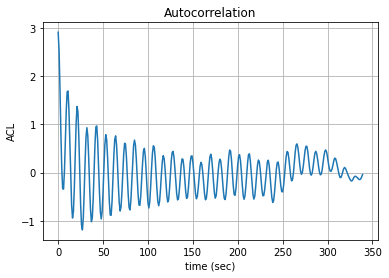

In [7]:
autocorr_buff = [] 
for lag in range(NUM_AUTOCORR_LAGS):
    temp_autocorr = 0.0
    for i in range(NUM_AUTOCORR_LAGS - lag):
        temp_autocorr += mag[i] * mag[i + lag]
    autocorr_buff.append(temp_autocorr)

t = []
for i in range(NUM_AUTOCORR_LAGS):
    t.append(i)
    
plt.plot(t, autocorr_buff)
plt.xlabel("time (sec)")
plt.ylabel("ACL")
plt.title("Autocorrelation")
plt.grid()
plt.show()


## 5)  Deriative filter

The derivative filter is used to calculate points of peaks. As the peaks represent zeros and roots when discrete derivative is taken. The derivative filter need to be calibrated for our particular setup.

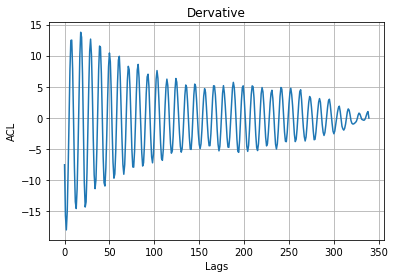

In [8]:
der = autocorr_buff.copy()
for k in range(len(der)-1):
    der[k] = (der[k+1]-der[k])/0.05
    
plt.plot(t, der)
plt.xlabel("Lags")
plt.ylabel("ACL")
plt.title("Dervative")
plt.grid()
plt.show()

## 6) Determine index of Peaks

The following algorithm looks for peaks, by searching for zeros from out of derivative filter.

Peak Found Up: 6,7.613054496975367
Peak Found Up: 16,2.7196142706819693
Peak Found Up: 27,5.066833077307322
Peak Found Up: 37,1.5110729147459723
Peak Found Up: 48,3.0755790209350953
Peak Found Up: 59,5.601018783013753
Peak Found Up: 69,1.6237864126345225
Peak Found Up: 80,4.017050069609318
Peak Found Up: 91,3.95727708103723
Peak Found Up: 101,2.477815837976205
Peak Found Up: 112,2.0250841394561903
Peak Found Up: 122,0.8076587623598019
Peak Found Up: 133,0.6045753850088698
Peak Found Up: 143,0.3738223695857301
Peak Found Up: 154,1.020690737852492
Peak Found Up: 164,0.46271207991960717
Peak Found Up: 175,1.0806861788485889
Peak Found Up: 186,2.442366418699211
Peak Found Up: 197,2.734480838242297
Peak Found Up: 207,1.3423228483174443
Peak Found Up: 218,1.2309391564386818
Peak Found Up: 228,0.09274360684335181
Peak Found Up: 239,0.7768976535102579
Peak Found Up: 250,2.2775271221139213
Peak Found Up: 260,0.44725860123002337
Peak Found Up: 271,0.8468146895445441
Peak Found Up: 282,1.08328717

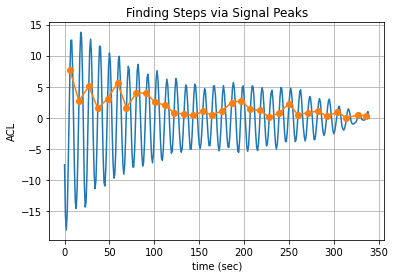

In [10]:
PEAK_QUALITY = 0.5
peaks = []
index_peaks = []
sign_positive = False
sign_negative = False
for k in range(len(der)-1):
    if der[k]>0 and sign_positive == False and sign_negative == True:
        if der[k+1] > PEAK_QUALITY:
            print("Peak Found Up: " + str(k) + "," + str(der[k]))
            peaks.append(der[k])
            index_peaks.append(k)
    
    if der[k] < 0:
        sign_negative = True
        sign_positive = False
        
    
    if der[k] > 0:
        sign_positive = True
        sign_negative = False
        
print("Steps Found: " + str(len(peaks)))
        
plt.plot(t, der)
plt.plot(index_peaks, peaks, '-o')
plt.xlabel("time (sec)")
plt.ylabel("ACL")
plt.title("Finding Steps via Signal Peaks")
plt.grid()
plt.show()

### Reference for Pedometer Algorithm

[1] https://github.com/nerajbobra/embedded_pedometer

[2] https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/p3225-morris.pdf
